<center><h1>Project Work</h1>
<b>Matteo Periani</b>, <b>Simone Mele</b>, <b>Gian Marco Baroncini</b>, and <b>Giuseppe Mantineo</b><br/>
Master's Degree in Artificial Intelligence, University of Bologna<br/>
{ matteo.periani2, simone.mele, gianmarco.baroncini, giuseppe.mantineo }@studio.unibo.it
</center>

In [1]:
# !make install
# !make download_data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re


import torch


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import datasets

from datasets.utils import disable_progress_bar
from collections import defaultdict


from src.config import Config
from src.utils import to_pandas, flatten, replace_str


from src.analysis import (
    plot_cls_distribution,
    plot_cls_counts,
    plot_cls_null_counts,
    print_n_annotations,
    print_txt_with_punctuations,
)

from src.data import (
    GroupLabelProcessor,
    classification_cols,
    generative_cols,
    is_annotation_valid,
    set_features_to_null_wrt_rules,
    white_space_fix,
    lower,
    aggregation_proposals_by_similarity,
    print_aggregation_proposals,
    filter_out_labels_with_multiple_concepts,
    split_on_and_or_slash,
    load_raw_data,
    rename_data_columns,
    split_group_labels,
    clean_data,
)


from src.text_similarity import (
    TextSimilarity,
    show_embedding_space,
)

# keep datasets in memory if < 8 GB
datasets.config.IN_MEMORY_MAX_SIZE = 8 * 1024**3
disable_progress_bar()
sns.set_theme()
matplotlib.rcParams["figure.figsize"] = (20, 10)


config = Config.load_config()

# Problem Description

The goal of our work is to build a model that is able to highlight biases and stereotypes, both implicit and explicit, from texts. To train our models we use SBIC corpus. The task our model must be able to solve may be divided into two sub-tasks:
1. categorical classification: 
    - the text is **offensive**
    - the offense is **intentional**
    - the text has sexual content (**sex**)
    - the offense targets a group, e.g. a minority, or an individual (**vs_group**)
    - the writer belongs to the targeted group (**in_group**)
2. free-form text generation:
    - the targetted group (**group**)
    - an explaination of the involved stereotype (**stereotype**)

# Data Analysis

In [44]:
data = load_raw_data(config)
data = rename_data_columns(data)

cols = data.column_names["train"]
print(cols)

['post', 'offensive', 'intentional', 'sex', 'vs_group', 'in_group', 'group_category', 'group', 'stereotype', 'sexReason', 'annotatorGender', 'annotatorMinority', 'sexPhrase', 'WorkerId', 'HITId', 'annotatorPolitics', 'annotatorRace', 'annotatorAge', 'source']


In [45]:
df = to_pandas(data)
df = df[df["split"] != "test"]
df.sample(10)

,post,offensive,intentional,sex,vs_group,in_group,group_category,group,stereotype,sexReason,annotatorGender,annotatorMinority,sexPhrase,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,source,split
53020,What would you call a shooting in a Boston Cat...,1.0,0.66,0.0,1.0,0.0,victim,mass shooting victims,trivializes harm to victims,None,man,None,None,6347880360297734464,35NNO802AVQ45MJ1FSFS5VLP01KNIH,mod-liberal,white,35.0,r/darkjokes,train
351,RT @BittyTang: &#8220;@Weed_Cloudz: Us calling...,0.5,0.33,0.0,1.0,0.0,gender,women,makes fun of how women dress,None,woman,women,None,-1563458821535984332,3OID399FXG1B9JQYPQV46TW37IKDFJ,liberal,white,22.0,t/davidson,train
41425,How to exterminate Muslims Walk around with a ...,1.0,1.00,0.0,1.0,0.0,culture,muslim folks,should be exterminated,None,woman,None,None,2428559182657536645,367O8HRHKG27DSCR2ZUAAOLCIFM4SK,liberal,white,29.0,r/darkjokes,train
106724,the same roasties who say sex is overrated any...,1.0,1.00,0.0,1.0,0.0,gender,women,women are shallow,None,woman,None,None,-3559048982681398316,3D7VY91L65RO0WKVXH8B6TSC3WHMBN,liberal,white,30.0,r/Incels,train
36276,"""""""An elite Red Bull training camp makes athle...",0.0,0.00,0.0,NaN,NaN,None,None,None,None,man,None,None,-7353159578349448466,3WA2XVDZEMBKIWBNKS3KI51BDDL6E4,mod-liberal,white,32.0,t/founta,train
66837,"Please, PLEASE start using ""is your discernmen...",0.0,0.00,0.0,NaN,NaN,None,None,None,None,woman,None,None,-5471608738051449110,3R6RZGK0XF633R7FL1NM109QEYYYVH,other,white,35.0,t/waseem,train
36186,@wolfblitzer @SenSanders @realDonaldTrump @CNN...,1.0,1.00,0.0,0.0,NaN,None,None,None,None,man,None,None,3014462452121555470,3P4ZBJFX2VXAIPQP6L0UYHLODGSWFC,mod-liberal,white,38.0,t/founta,train
104535,/r/AskReddit thread about sexual acts in priso...,0.0,0.00,1.0,NaN,NaN,None,None,None,self explanatory,man,None,sexual acts in prison,4554125108380068779,3MGHRFQY2LJNAQ6ZI4ZXG7J0L2WY01,mod-liberal,white,25.0,r/MensRights,train
6966,Niggas aint worried bout other niggas messin w...,1.0,1.00,1.0,1.0,0.0,race,black folks,is inherently bad,having sex with,woman,None,messin with,-6352039173957003457,3ECKRY5B1QQYMBXKIGQM0ISYBT5ZIG,mod-cons,white,36.0,t/davidson,train
114625,I hate when people use my stuff without asking...,0.0,0.00,0.0,NaN,NaN,None,None,None,None,man,None,None,-5870881806826799680,3DIIW4IV8PPIJE9VXN0W6MFPBYKI46,liberal,white,35.0,t/founta,val


The two sub-tasks may involve different approaches. We start by analysing classification features.

In [6]:
df_cls = df[classification_cols + ["split"]]

Numbers in the classification features have the following meaning (from 0. to 1.):
- **offensive**: no, maybe, yes
- **intentional**: no, probably no, probably yes, yes
- **sex**: no, maybe, yes
- **vs_group**: no, yes
- **in_group**: no, maybe, yes

The histograms belows show that the dataset is very imbalanced.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

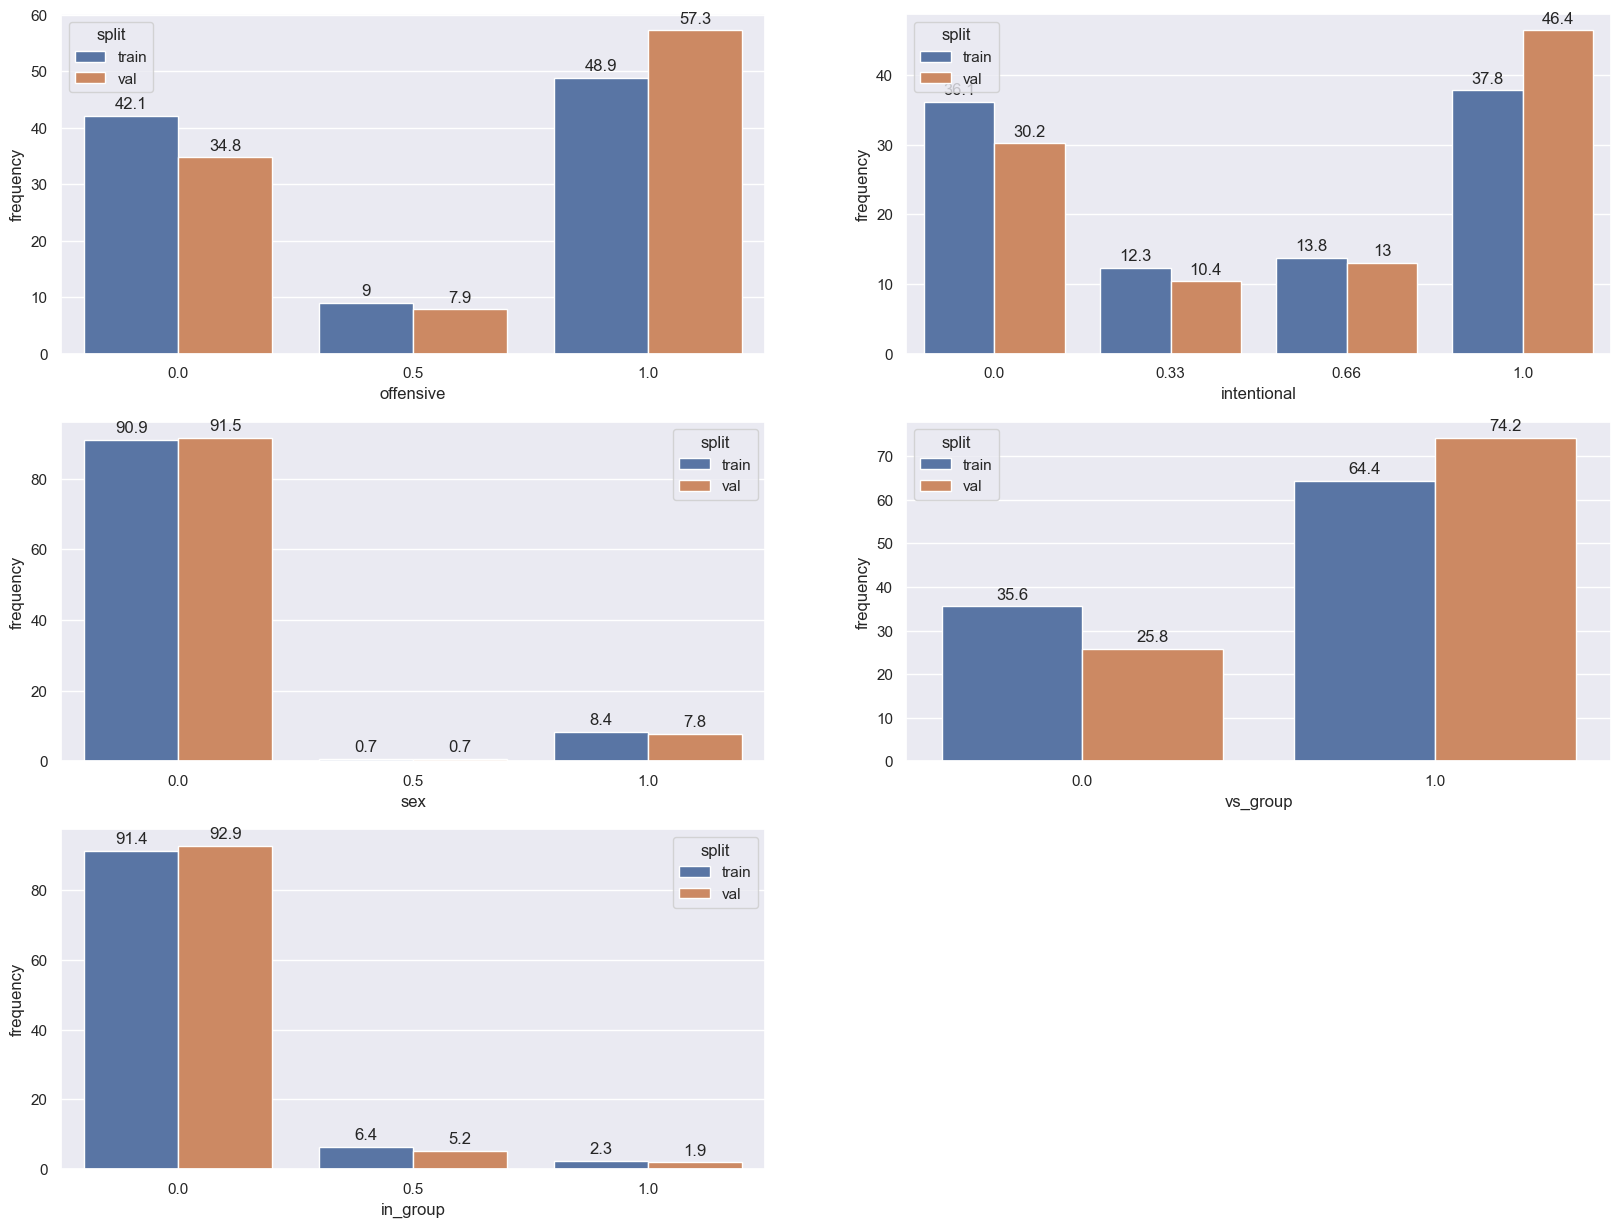

In [7]:
plot_cls_distribution(df_cls, cls_cols=classification_cols, type="bar");

As shown by the plots below, there are more posts annotated as intentional or sex than the ones annotated as offensive. We must investigate this issue, as the paper states that:
1. annotators indicate whether the post is offensive, whether the intent was to offend, and whether it contains lewd or sexual content.
2. if annotators indicate potential offensiveness do they answer the group implication question. Hence, `offensive => vs_group not None`.
3. if post targets a group, annotators write which one. Hence, `vs_group => group not None`.
4. for each selected group, annotators write two to four stereotypes. Hence, each group has about 2-4 stereotypes.
5. annotators indicate if the writer of the post is part of one of the minority groups referenced. Hence, `vs_group => in_group not None`.

In [8]:
print_n_annotations(df_cls)

Total number of annotations: 129638
- train: 112900
- val: 16738


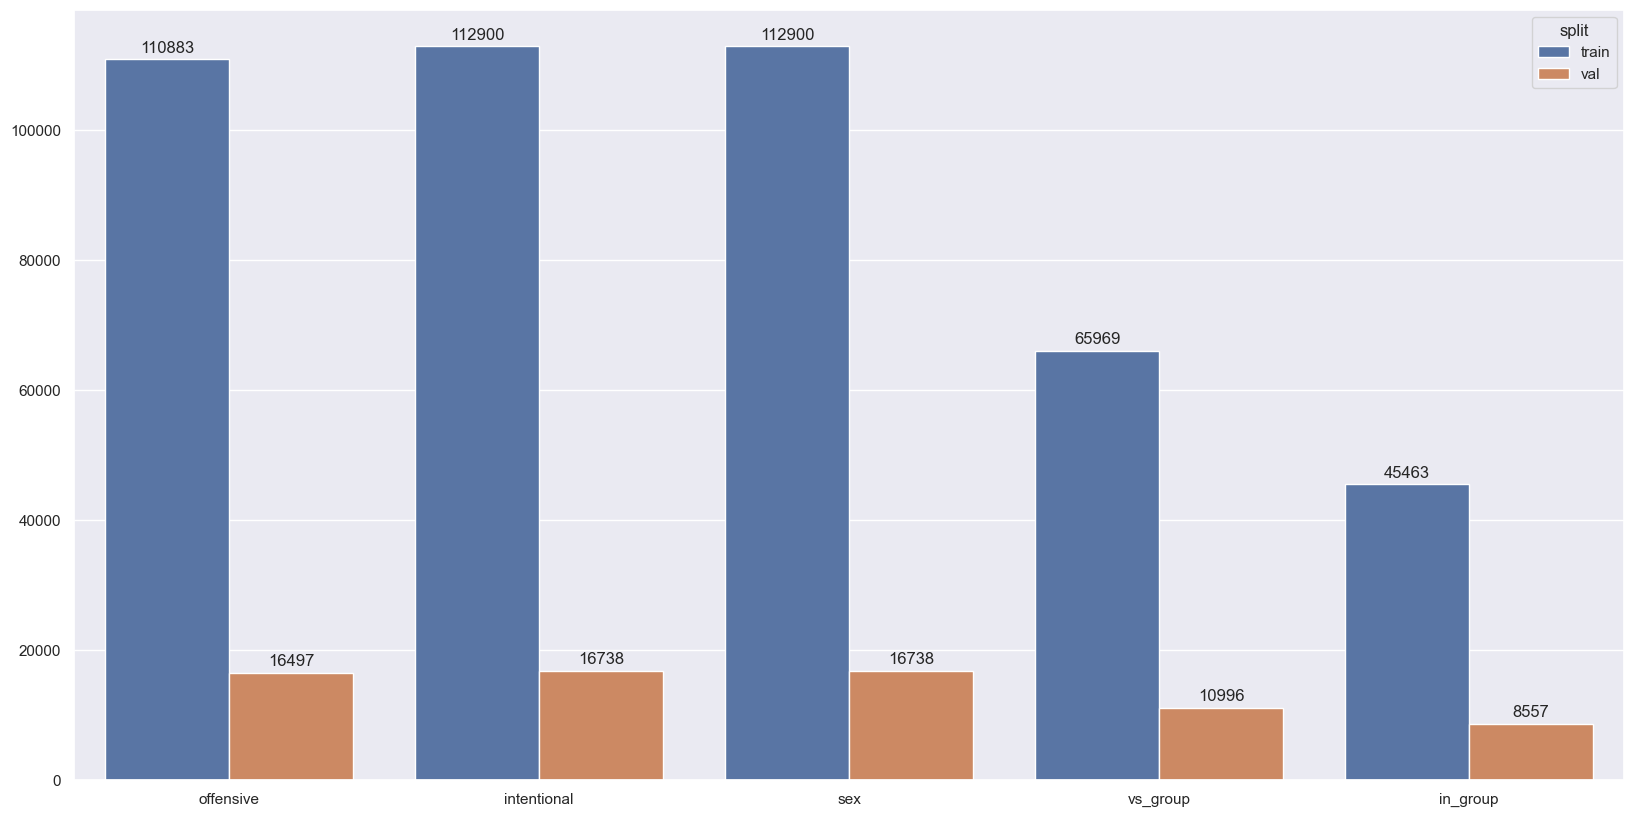

In [9]:
plot_cls_counts(df_cls, cls_cols=classification_cols)

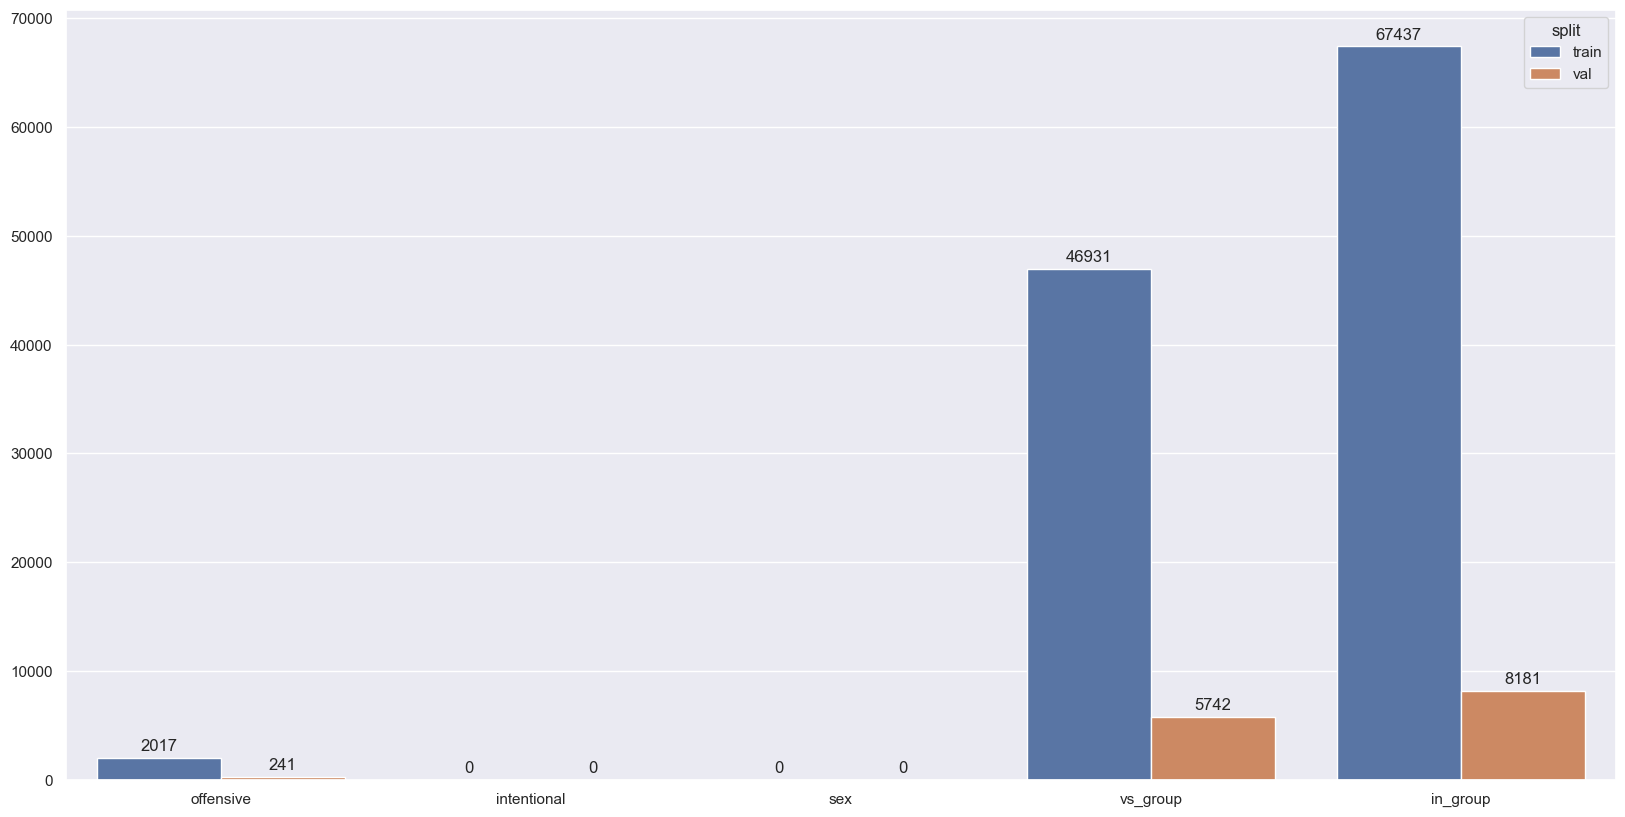

In [10]:
plot_cls_null_counts(df_cls, cls_cols=classification_cols)

Since wrongly annotated posts according to (1) are about 1.5% of the total posts, we just remove them from the dataset.

In [11]:
df_cls = df_cls[df_cls["offensive"].notnull()]
print_n_annotations(df_cls)

Total number of annotations: 127380
- train: 110883
- val: 16497


Now, we must ensure that `offensive => vs_group not None`.

In [12]:
df_valid = df_cls[(df_cls["offensive"] > 0.0) & (df_cls["vs_group"].notnull())]
df_non_valid = df_cls[(df_cls["offensive"] > 0.0) & (df_cls["vs_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 74971
- train: 64210
- val: 10761

Total number of non valid annotations: 0


And that `vs_group => in_group not None`. Again. since we have only 4 invalid annotations, we remove them from the dataset.

In [13]:
vs_group = (df_cls["offensive"] > 0.0) & (df_cls["vs_group"] > 0.0)
df_valid = df_cls[vs_group & (df_cls["in_group"].notnull())]
df_non_valid = df_cls[vs_group & (df_cls["in_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

df_cls = df_valid

Total number of valid annotations: 50505
- train: 42361
- val: 8144

Total number of non valid annotations: 4
- train: 4


In [14]:
offensive_not_null = df["offensive"].notnull()
df = df[offensive_not_null]

offensive = df["offensive"] > 0.0
group_not_null = df["vs_group"].notnull()
df = df[(~offensive) | (offensive & group_not_null)]

offensive = df["offensive"] > 0.0
vs_group = offensive & (df["vs_group"] > 0.0)
in_group_not_null = df["in_group"].notnull()
df = df[(~vs_group) | (vs_group & in_group_not_null)].reset_index(drop=True)

print_n_annotations(df)

Total number of annotations: 127376
- train: 110879
- val: 16497


We ensure that `vs_group => group not None`.

In [15]:
vs_group = (df["offensive"] > 0.0) & (df["vs_group"] > 0.0)
df_valid = df[vs_group & (df["group"].notnull())]
df_non_valid = df[vs_group & (df["group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 50505
- train: 42361
- val: 8144

Total number of non valid annotations: 0


It's time to filter out invalid annotations from the dataset and to set to None the features according to the rules stated above. 

In [16]:
print("Number of annotations before removing invalid annotations:")
print(data.num_rows)

data = data.filter(is_annotation_valid)

print("Number of annotations after removing invalid annotations:")
print(data.num_rows)
print()

print("Setting target features to None according to annotation rules...")
data = data.map(set_features_to_null_wrt_rules)

Number of annotations before removing invalid annotations:
{'train': 112900, 'val': 16738, 'test': 17501}
Number of annotations after removing invalid annotations:
{'train': 110879, 'val': 16497, 'test': 17269}

Setting target features to None according to annotation rules...


## Group labels analysis and reduction

For each post, our model has to predict a set of targeted groups. So, we cannot solve the task as a classic classification problem, but we may approach it as a generative task. Nevertheless, we can try to reduce the space of generated groups, by semantically aggregating such labels. We think that diversity is not a good thing we want our network to have for this task. Hence, reducing the space of group labels will increase data quality and, consequently, network accuracy.

First of all, we visualize all the groups divided by category.

In [17]:
df = to_pandas(data)
df_groups = df[df["group"].notnull()]

n_groups = len(df["group"].unique())

print("Number of unique groups:", n_groups)
print()


groups_by_category = df_groups.groupby("group_category")["group"].apply(set)

for category, pieces in groups_by_category.items():
    print(category)
    print(list(pieces))
    print()

Number of unique groups: 1404

body
['Attractive folks', 'Young kids', 'minor girls', 'young girls', 'uncles', 'anorexic', 'Millenials/Generation Z', 'bald folks', 'younger genereration', 'old folks, overweight/fat folks', 'unwed non parents', 'orphans', 'little people', 'blondes', 'virgins', 'skinny folks', 'millennials', 'overweight/fat folks, ugly folks', 'men with small penises', 'young kids', 'ginger folks', 'Younger people', 'Blondes', 'breast size', 'skinny men', 'anorexics', 'young folks', 'gingers', 'seniors', 'overweight/fat folks', 'nonmasculine men', '18 year olds', 'Teens', 'Parents', 'blonde women', 'teen moms', 'pregnant teenagers', 'babies', 'pedophiles', 'cancer patients', 'anorexic folks', 'red heads', 'blonde', 'pregnant folks', 'minors', 'disabled people', 'Children', 'pregnant folks, parents', 'Young boys', 'Gemini', 'emo', 'kids', 'ugly folks', 'shorts folks', 'blonde folks', 'sexual women', 'children', 'overweight/fat folks, ugly folks, "incels" or celibate not b

In [18]:
pieces = flatten(df_groups["group"].apply(split_group_labels))
pieces = [lower(group) for group in pieces]
print("Number of unique groups:", np.unique(pieces).size)

Number of unique groups: 1125


We have slash-separated labels that can be splitted in a set of labels.

We want to reduce the number of labels according to their semantic meaning. As an example, `blacks` and `black people` represent the same concept. Therefore, we keep only one of them. We try to cluster labels in a semi-automated manner, exploiting a text-embedding model. According to [MTEB](https://arxiv.org/abs/2210.07316), the best embedding model for text similarity is [UAE-Large-V1](https://huggingface.co/WhereIsAI/UAE-Large-V1).

In [19]:
text_similarity = TextSimilarity(config.embedding_model)
group_lbl_processor = GroupLabelProcessor(pieces)
group_lbl_processor.remove_double_spaces()
group_labels = group_lbl_processor.label_list()
print("Number of unique groups:", len(group_labels))

Number of unique groups: 1001


In [20]:
embedding_space = text_similarity.generate_embeddings(group_labels)
similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(
    embedding_vectors=embedding_space
)

The (low-dimensional projection of the) embedding space shows some clusters. 

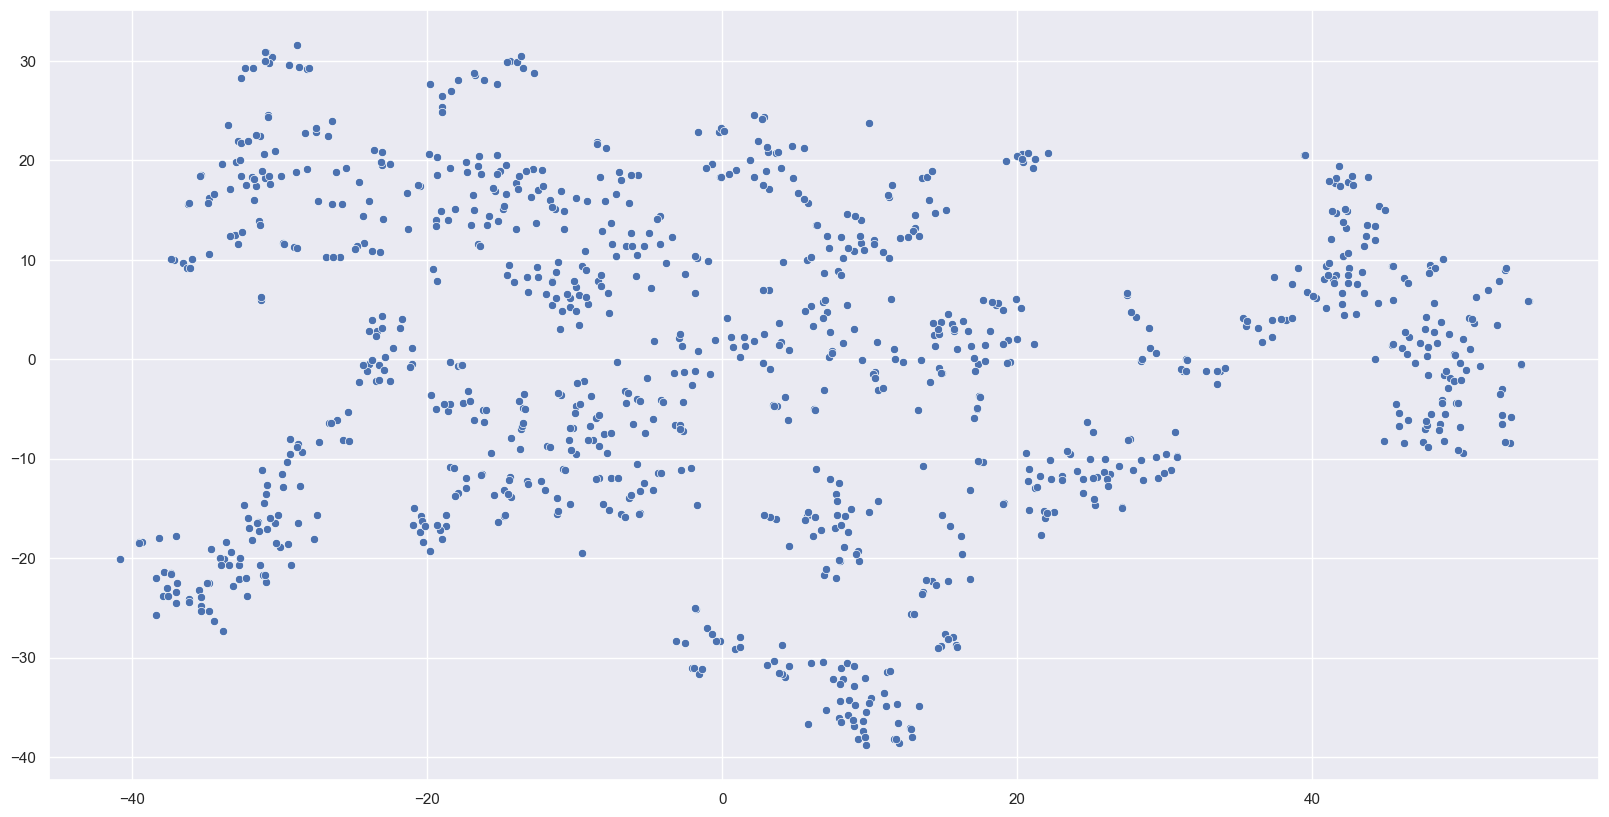

In [21]:
show_embedding_space(embedding_space, pca_components=20)

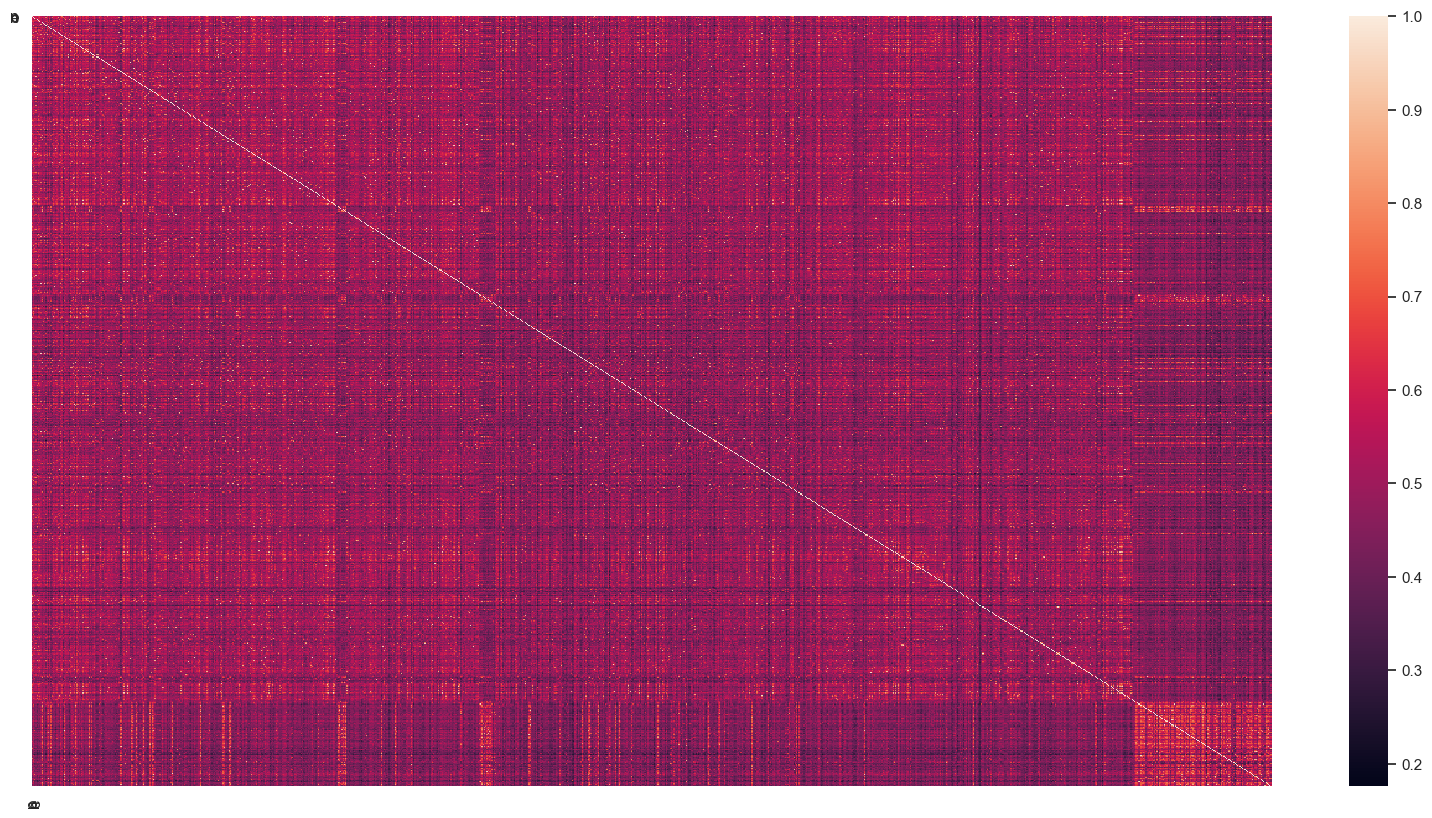

In [22]:
ax = sns.heatmap(similarity_matrix, xticklabels="none", yticklabels="none")

Most of the labels have very low similarity. Let's set a threshold.

<Axes: >

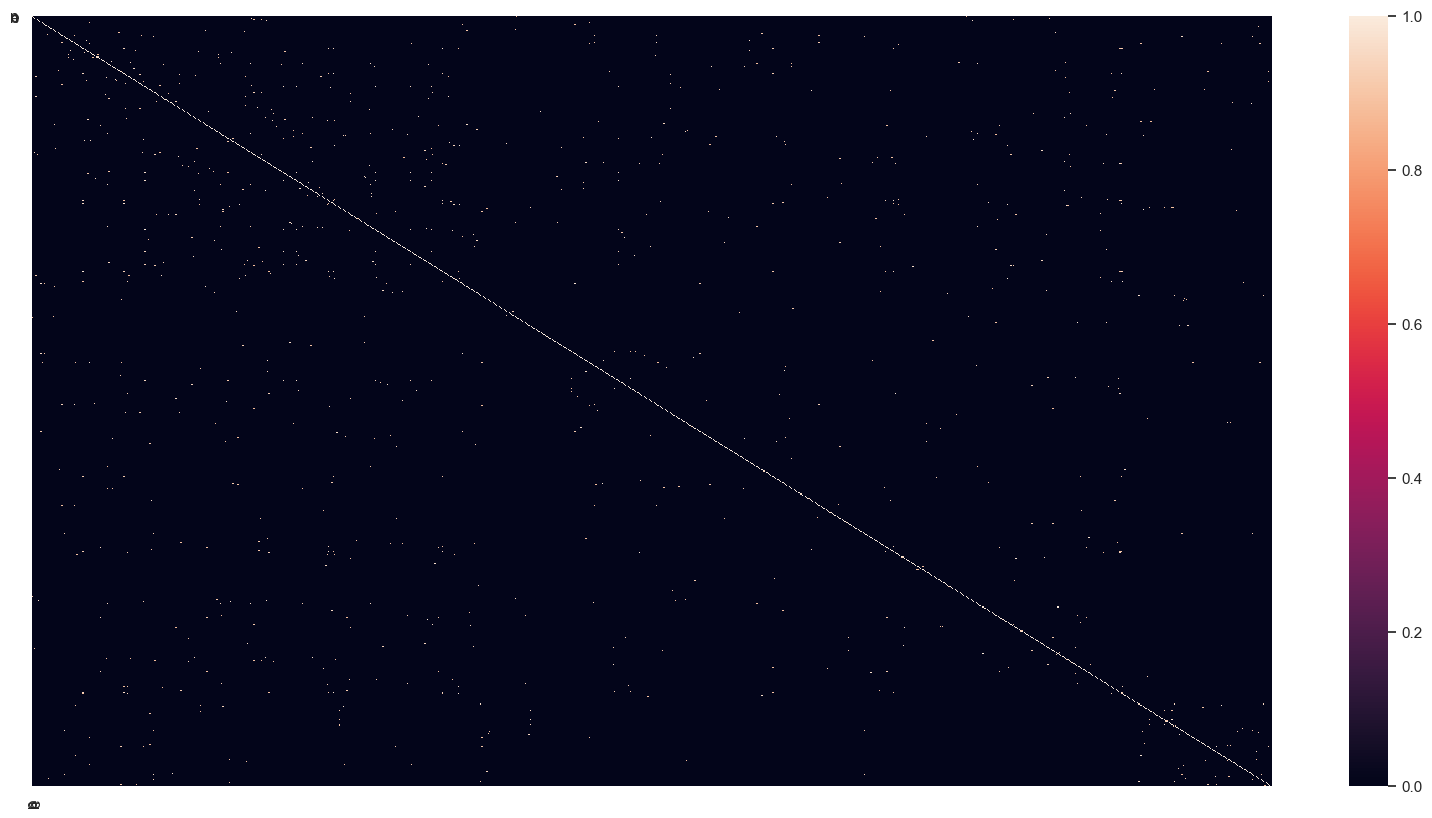

In [23]:
threshold = 0.88
sns.heatmap(
    similarity_matrix * (similarity_matrix > threshold),
    xticklabels="none",
    yticklabels="none",
)

In [24]:
aggregation_proposals = aggregation_proposals_by_similarity(
    group_labels, similarity_matrix, threshold=threshold
)
print_aggregation_proposals(aggregation_proposals, group_lbl_processor.groups_count)

black folks (18412): {'blacks', 'light skinned black folks'}
jewish folks (5898): {'jewish folk', 'jewish people'}
muslim folks (2656): {'islamic folks', 'muslim', 'islamic people', 'muslims'}
gay men (1924): {'gay folks', 'homosexual men', 'gay people'}
asian folks (1730): {'asian people', 'asians'}
physically disabled folks (1380): {'disabled folks', 'the handicapped', 'disabled people'}
assault victims (1016): {'sex assault victims', 'sexual assault victims'}
mentally disabled folks (974): {'disabled folks', 'disabled people'}
folks with mental illness/disorder (691): {'folks with physical illness/disorder'}
mass shooting victims (659): {'shooting victims'}
native american/first nation folks (565): {'indigenous folks'}
overweight/fat folks (516): {'fat people', 'fat folks'}
arabic folks (488): {'arab folks'}
feminists (423): {'feminist', 'feminist women'}
trans men (420): {'cis men'}
folks with physical illness/disorder (365): {'folks with mental illness/disorder'}
africans (304): {

At a first sight, results seem very good. Let's start by inspecting groups that have punctuations.

In [25]:
print_txt_with_punctuations(group_labels)

Punctuation: /
independents/libertarians
gypsies/ romani
rednecks/south region in the us
latino/latina folks
german people/jewish people
sexual assault/rape victims
folks with mental illness/disorder
syrians/russians
millenials/generation z
middle east/africa
native american/first nation folks
folks with physical illness/disorder
people who self-harm/are suicidal
victims of 9/11
gay/lesbians
africa/middle east
middle eastern / arabic people
brown/asian people
members of the irish repulbican army and/or the ira political group in ireland.
indian/pakistani people
any racial/ethnic minority in america
overweight/fat folks
priests/nuns
eastern/indian people
southerners/ rednecks
rural/ country folks
everyone/parents/children
kidnap/violence/murder victims
bullimacs/anorexics
pakistan/indian people
holocaust survivors/jews

Punctuation: -
non-white folks
mixed-race folks
non-europeans
non-white
any non-white
self-harming people
non-christians
people who self-harm/are suicidal
middle-eastern

From the analysis above, we have that:
1. text between parenthesis is irrelevant. We remove it.
2. `? ' " .` are irrelevant. We remove them, paying attention to keep `'s 't`.
3. `-` can be replaced by space.

In [26]:
punct_substitution_map = {
    r"\(.*\)": " ",
    r'[\?".]': " ",
    r"'(?![st])": " ",
    r"\s*-\s*": " ",
    r"\band\s*/\s*or\b": "or",
}
group_lbl_processor.rename_groups(punct_substitution_map)
group_lbl_processor.remove_double_spaces()
group_labels = group_lbl_processor.label_list()

print("Number of unique groups:", len(group_labels))
print()
print_txt_with_punctuations(group_labels)

Number of unique groups: 981

Punctuation: /
independents/libertarians
gypsies/ romani
rednecks/south region in the us
latino/latina folks
german people/jewish people
sexual assault/rape victims
folks with mental illness/disorder
syrians/russians
millenials/generation z
middle east/africa
native american/first nation folks
folks with physical illness/disorder
victims of 9/11
gay/lesbians
africa/middle east
middle eastern / arabic people
brown/asian people
indian/pakistani people
any racial/ethnic minority in america
overweight/fat folks
priests/nuns
eastern/indian people
southerners/ rednecks
rural/ country folks
everyone/parents/children
kidnap/violence/murder victims
bullimacs/anorexics
people who self harm/are suicidal
pakistan/indian people
holocaust survivors/jews

Punctuation: '
jehova's witnesses
gypsy's
jehovah's witnesses
folks with alzheimer's
germans and anyone that's sensitive about the hol
people who's fathers have left them
women's who ve had abortions
anyone that isn't w

Morover, to reduce labels to inspect by hand, let's craft some deterministic rules based on aggregations found:
1. people, persons and folks are used interchangeably. Hence, we change folk(s) into people.
2. children and kids are used interchangeably. We keep children.
3. illness and disorder are used interchangeably. We keep illness.
4. fat and overweight are used interchangeably. We keep fat.

Labels containing a slash or an and/or conjunction may contain multiple concepts. Therefore, we ignore them at the moment.

In [27]:
substitution_map = {
    r"\b(?:(?:illness\s*/\s*disorders?)|(?:disorders?\s*/\s*illness)|(?:disorders?))\b": "illness",
    r"\b(?:(?:fat\s*/\s*overweight)|(?:overweight\s*/\s*fat)|(?:overweight))\b": "fat",
}
group_lbl_processor.rename_groups(substitution_map)

substitution_map = {
    r"\b(folks?)|(persons?)\b": "people",
    r"\bkids\b": "children",
}
group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)
group_lbl_processor.rename_groups(substitution_map, groups=single_concept_labels)

group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)
print("Number of unique groups:", len(group_labels))
print("Number of unique groups w/o slash, and, or:", len(single_concept_labels))

Number of unique groups: 926
Number of unique groups w/o slash, and, or: 881


We know that most of the nationalities have the suffix `an`. Therefore, we can hardcode such rules.

In [28]:
aggregation_preferences = defaultdict(list)
label_set = set(group_labels)

for lbl in single_concept_labels:
    match = re.search(r"(.+)n people", lbl)
    if match is not None:
        nation = match.group(1)
        nationality = nation + "n"

        if nation in label_set:
            aggregation_preferences[lbl].append(nation)
        if nationality in label_set:
            aggregation_preferences[lbl].append(nationality)

print_aggregation_proposals(aggregation_preferences, group_lbl_processor.groups_count)

asian people (1732): ['asia', 'asian']
african people (202): ['africa', 'african']
indian people (98): ['india', 'indian']
mexican people (96): ['mexican']
ethiopian people (85): ['ethiopia', 'ethiopian']
middle eastern people (34): ['middle eastern']
syrian people (22): ['syria', 'syrian']
german people (14): ['german']
russian people (12): ['russia', 'russian']
nigerian people (10): ['nigeria']
saudi arabian people (10): ['saudi arabia']
afghan people (8): ['afghan']
korean people (8): ['korea']
italian people (6): ['italian']
arabian people (4): ['arabian']
jamaican people (4): ['jamaica', 'jamaican']
pagan people (3): ['pagan']
malaysian people (2): ['malaysia']
pakistan people (2): ['pakistan']
somalian people (2): ['somalia', 'somalian']
cambodian people (2): ['cambodia']
palestinian people (2): ['palestinian']
egyptian people (2): ['egyptian']


Let's inspect groups ending with term `people`.

In [29]:
similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(single_concept_labels)
aggregation_proposals = aggregation_proposals_by_similarity(
    single_concept_labels, similarity_matrix, threshold=threshold
)
people_agg_proposals = {

    group: agg

    for group, agg in aggregation_proposals.items()

    if group.endswith("people")

}

print_aggregation_proposals(people_agg_proposals, group_lbl_processor.groups_count)

black people (18412): {'light skinned black people', 'blacks', 'people of african descent', 'any black people'}
jewish people (5908): {'jews', 'jewish'}
muslim people (2656): {'muslim', 'islamic people', 'muslims'}
asian people (1732): {'asian', 'asians'}
physically disabled people (1380): {'the handicapped', 'disabled people'}
mentally disabled people (974): {'disabled people'}
arabic people (488): {'arab people'}
white people (296): {'whites'}
african people (202): {'black africans', 'people of african descent', 'africans'}
indian people (98): {'people from india'}
mexican people (96): {'mexicans'}
ethiopian people (85): {'ethiopian', 'ethiopians'}
non white people (40): {'all non white people', 'american non whites', 'all non whites', 'any non white people', 'non whites', 'non white'}
middle eastern people (34): {'middle eastern', 'middle easterners', 'people from the middle east', 'middle easterns'}
irish people (30): {'irishmen'}
young people (25): {'younger people'}
islamic peopl

Before automatically merging all groups, we want to prevent some aggregation to happens and to force other ones.

In [30]:
aggregation_blacklist = [
    ("black people", "people of african descent"),

    ("black people", "light skinned black people"),
    ("physically disabled people", "disabled people"),
    ("mentally disabled people", "disabled people"),
    ("the handicapped", "disabled people"),

    ("gay people", "homosexual people"),

    ("gay people", "homosexuals"),

    ("gay people", "queer people"),

    ("homosexual people", "homosexual men"),

    ("gays", "homosexuals"),

    ("gays", "homosexuals"),

    ("homosexual men", "homosexuals"),

    ("lgbtq+ people", "queer people"),
    ("interracial people", "interracial couples"),

    ("gendered people", "gender fluid people"),

]


aggregation_preferences.update(
    {
        "american southern people": ["southern people"],
        "physically disabled people": ["the handicapped"],
    }
)

We have some labels containing the fact and others where the fact is followed by `victims` or `survivors`, e.g. `sex assault victims`. Let's aggregate them.

In [31]:
victims_aggregates = defaultdict(list)

for lbl in single_concept_labels:
    match = re.match(r"(.+) \b(survivor|victim)s?\s*$", lbl)
    if match is not None:
        fact = match.group(1)
        dest_group = f"{fact} {match.group(2)}s"

        if fact in label_set:
            victims_aggregates[dest_group].append(fact)
        if dest_group != lbl:
            victims_aggregates[dest_group].append(lbl)

victims_aggregates.pop("homeless victims")
aggregation_preferences.update(victims_aggregates)
print_aggregation_proposals(victims_aggregates, group_lbl_processor.groups_count)

holocaust victims (272): ['holocaust']
rape victims (144): ['rape', 'rape', 'rape victim']
sexual assault victims (80): ['sexual assault', 'sexual assault', 'sexual assault victim']
pedophilia victims (27): ['pedophilia']
suicide victims (21): ['suicide']
holocaust survivors (21): ['holocaust']
incest victims (19): ['incest']
domestic abuse victims (10): ['domestic abuse']
child murder victims (4): ['child murder']
kidnap victims (0): ['kidnap victim']
jewish victims (2): ['jewish']
child rape victims (35): ['child rape victim']
tragedy victims (1): ['tragedy victim']
sexual assault survivors (1): ['sexual assault']
mass accident victims (1): ['mass accident']
miscarriage survivors (1): ['miscarriage']
police shooting victims (0): ['police shooting victim']
miscarriage victims (1): ['miscarriage']
assassination victims (1): ['assassination victim']


Now, let's inspect remaining labels.

In [32]:
remaining_agg_proposals = {
    group: agg
    for group, agg in aggregation_proposals.items()
    if not group in people_agg_proposals
}

print_aggregation_proposals(remaining_agg_proposals, group_lbl_processor.groups_count)

gay men (1924): {'homosexual men', 'gay people'}
assault victims (1016): {'sex assault victims', 'sexual assault victims'}
mass shooting victims (659): {'shooting victims'}
feminists (423): {'feminist', 'feminist women'}
trans men (420): {'cis men'}
people with physical illness (365): {'sick people'}
africans (304): {'african', 'people of african descent', 'black africans', 'african people'}
holocaust victims (272): {'holocaust victimes', 'holocaust survivors'}
children (257): {'young children'}
ethiopians (217): {'ethiopian', 'ethiopian people'}
rape victims (144): {'sex assault victims', 'rape victim', 'sexual assault victims'}
people of color (125): {'people of different races'}
non whites (99): {'all non white people', 'american non whites', 'all non whites', 'any non white people', 'any non white', 'non white people', 'non white', 'nonwhite'}
sexual assault victims (80): {'sexual assault survivors', 'assault victims', 'sex assault victims', 'rape victims', 'sex abuse victims', 'se

In [33]:
aggregation_blacklist.extend(
    [
        ("assault victims", "sexual assault victims"),
        ("assault victims", "sex assault victims"),
        ("sexual assault victims", "child sexual assault victims"),
        ("sex assault victims", "child sexual assault victims"),
        ("sex abuse victims", "child sexual abuse victims"),
        ("sex abuse victims", "victims of child sexual abuse"),
        ("abuse victims", "domestic abuse victims"),
        ("abuse victims", "sex abuse victims"),
        ("abuse victims", "child abuse victims"),
        ("straight white men", "white men"),
        ("straight white men", "white guys"),
        ("minorities", "racial minorities"),
        ("minorities in general", "racial minorities"),
        ("minority", "racial minorities"),
        ("minority groups", "racial minorities"),
        ("minority people", "racial minorities"),
        ("all minorities", "all racial minorities"),
        ("accident victims", "car accident victims"),
        ("accident victims", "auto accident victims"),
        ("accident victims", "car crash victims"),
        ("all colored races", "all races"),
        ("people of color", "people of different races"),
        ("trans men", "cis men"),
        ("refugees", "syrian refugees"),
        ("murder victims", "murder victim families"),
        ("molestation victims", "child molestation victims"),
        ("people of different races", "people of color"),
        ("american non whites", "non americans"),
        ("non europeans", "non americans"),
    ]
)



aggregation_preferences.update(
    {
        "black people": ["people of color"],
        "women with small breasts": ["woman with small breasts"],
    }
)

In [34]:
preferences = {
    group: aggregation_preferences.pop(group, [])
    for group in people_agg_proposals.keys()
}
preferences.update(aggregation_preferences)
group_lbl_processor.aggregate(aggregation_proposals, aggregation_blacklist, preferences)

group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)

print("Number of unique groups:", len(group_labels))
print("Number of unique groups w/o slash, and, or:", len(single_concept_labels))

Number of unique groups: 632
Number of unique groups w/o slash, and, or: 587


It's time to handle groups that have a slash or an and/or conjuction. It's very likely that they are a combination of at least two groups. Therefore, we try to divide and extract these labels.

In [35]:
slash_and_or_labels = np.setdiff1d(group_labels, single_concept_labels).tolist()
label_space = [
    lower(white_space_fix(replace_str(label, punct_substitution_map)))
    for label in group_lbl_processor.processed_labels
]
label_space = np.setdiff1d(label_space, slash_and_or_labels).tolist()
embedding_space = text_similarity.generate_embeddings(label_space)

split_map = split_on_and_or_slash(slash_and_or_labels)

Initially, we split the labels and retain the resulting groups if each group is one word long. We compute similiarity of these groups with already observed labels in order to aggregate them.

In [36]:
most_similar = text_similarity.retrieve_n_most_similar(
    queries=flatten(split_map.values()),
    documents=label_space,
    documents_embeddings=embedding_space,
    n=1,
)
split_map = group_lbl_processor.map_split_if_all_groups_are_one_word_longs(
    split_map, most_similar, threshold, verbose=True)

bullimacs/anorexics --> ['bullimacs', 'anorexics']
   bullimacs ('furry', 0.57818216) --> bullimacs
   anorexics ('anorexics', 1.0000002) --> anorexic people

everyone/parents/children --> ['everyone', 'parents', 'children']
   everyone ('everyone', 1.0000004) --> everyone
   parents ('parents', 1.0) --> parents
   children ('children', 1.0) --> children

gay/lesbians --> ['gay', 'lesbians']
   gay ('lgbt', 0.8647851) --> gay
   lesbians ('lesbian women', 0.94585645) --> lesbian women

girls and boys --> ['girls ', ' boys']
   girls  ('girls', 1.0000001) --> girls
    boys ('boys', 1.0) --> young boys

gypsies/ romani --> ['gypsies', ' romani']
   gypsies ('gypsies', 1.0000001) --> gypsies
    romani ('romani people', 0.92928934) --> roma people

independents/libertarians --> ['independents', 'libertarians']
   independents ('minority groups', 0.62923884) --> independents
   libertarians ('liberals', 0.74374115) --> libertarians

priests/nuns --> ['priests', 'nuns']
   priests ('priest

Then, we try to build groups according to four different strategies:
1. we take each group as is.
2. we take the words at the end of the original label and append them to each resulting group.
3. we take the words at the beginning of the original label and prepend them to each resulting group.
4. we combine points 3 and 4.
Subsequently, for each group we keep the best strategy according to the similarity with the already observed labels. If all the obtained groups have a similarity score higher than the threshold, we apply the spli and map rules.

In [37]:
def print_label_to_groups_mapping(
    label, best_alternatives, sim_groups, sim_scores, dest_groups
):
    print(label)
    for best_alternative, sim_group, sim_score, dest_group in zip(
        best_alternatives, sim_groups, sim_scores, dest_groups
    ):
        print(
            "-->",
            best_alternative,
            (sim_group, sim_score),
            "-->",
            dest_group,
        )
    print("-" * 30)

In [38]:
slash_and_or_labels = np.setdiff1d(
    slash_and_or_labels, list(group_lbl_processor.label_to_groups_map.keys())
).tolist()

for label, pieces in split_map.copy().items():
    groups = []
    groups.append(pieces)

    # append words at the end to each group
    # separate the first word of last group from all the rest
    match = re.search(r"(\w+)(.*)$", pieces[-1])
    last_group = match.group(1).strip()
    words_at_end = match.group(2).strip()
    pieces_ = pieces.copy()
    pieces_[-1] = last_group
    groups.append([f"{group.strip()} {words_at_end}".strip() for group in pieces_])

    # prepend words at the beginning to each group
    # separate the last word of first group from all the rest
    match = re.search(r"(.*\b)(\w+)\s*$", pieces[0])
    words_at_beginning = match.group(1).strip()
    first_group = match.group(2).strip()
    pieces_ = pieces.copy()
    pieces_[0] = first_group
    groups.append(
        [f"{words_at_beginning} {group.strip()}".strip() for group in pieces_]
    )

    # prepend words at the beginning and append words at the end to each group
    pieces_ = pieces.copy()
    pieces_[0] = first_group
    pieces_[-1] = last_group
    groups.append(
        [
            f"{words_at_beginning} {group.strip()} {words_at_end}".strip()
            for group in pieces_
        ]
    )

    groups = np.asarray(groups).T.tolist()
    best_alternatives = []
    sim_groups = []
    sim_scores = []
    dest_groups = []
    for alternatives in groups:
        similarity_matrix = text_similarity.compute_similarity_matrix(
            alternatives, documents_embeddings=embedding_space
        )
        index = np.unravel_index(
            np.argmax(similarity_matrix), shape=similarity_matrix.shape
        )
        best_alternative = alternatives[index[0]]
        similar_group = label_space[index[1]]
        similar_score = similarity_matrix[index]
        dest_group = group_lbl_processor.get_dest_group(
            similar_group if similar_score > threshold else best_alternative
        )

        best_alternatives.append(best_alternative)
        sim_groups.append(similar_group)
        sim_scores.append(similar_score)
        dest_groups.append(dest_group)
        
    if all(score > threshold for score in sim_scores):
        group_lbl_processor.map_split_to_groups(label, dest_groups)
        split_map.pop(label)

        print_label_to_groups_mapping(label, best_alternatives, sim_groups, sim_scores, dest_groups)

africa/middle east
--> africa ('africa', 1.0) --> african people
--> middle east ('middle east', 0.99999994) --> middle eastern people
------------------------------
all minorities and non whites
--> all minorities  ('all minorities', 0.9999999) --> minority people
--> all non whites ('all non whites', 0.99999994) --> non white people
------------------------------
all minorities and women
--> all minorities  ('all minorities', 1.0) --> minority people
-->  women ('women', 1.0) --> women
------------------------------
brown/asian people
--> brown people ('brown people', 1.0) --> brown people
--> asian people ('asian people', 0.99999976) --> asian people
------------------------------
deaf and blind people
--> deaf people ('deaf people', 1.0000005) --> deaf people
-->  blind people ('blind people', 1.0) --> blind people
------------------------------
german people/jewish people
--> german people ('german people', 0.9999999) --> german people
--> jewish people ('jewish people', 0.9999999

Remaining labels can be manually processed, but we prefer not to do it and keep them as they are.

In [39]:
slash_and_or_labels = np.setdiff1d(
    slash_and_or_labels, list(group_lbl_processor.label_to_groups_map.keys())
).tolist()
slash_and_or_labels

['any racial/ethnic minority in america',
 'christians and groups victimized by hitler',
 'eastern/indian people',
 "germans and anyone that's sensitive about the hol",
 'incels or celibate not by choice',
 'incels or reluctantly celebate people who identify themselves as incels',
 'latino/latina folks',
 'members of the irish repulbican army or the ira political group in ireland',
 'millenials/generation z',
 'people from north and south korea',
 'rednecks/south region in the us',
 'rural/ country folks',
 'victims of 9/11',
 'victims of poverty and starvation',
 'victims of racial and homophobic attacks',
 'zimbabwe and south africa']

Lastly, we want to see wheter groups generated from the same label are similar. In case of positive answer, we just remove the split and add a map from the label to one of the two groups.

In [40]:
for label, groups in group_lbl_processor.label_to_groups_map.copy().items():
    similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(groups)
    if np.all(similarity_matrix > threshold):
        group_lbl_processor.map_group(label, groups[0])
        group_lbl_processor.label_to_groups_map.pop(label)
        print(label, "-->", groups)

holocaust victims and survivors --> ['holocaust victims', 'holocaust victims']
sexual assault/rape victims --> ['rape victims', 'rape victims']


In [41]:
group_lbl_processor.save(config.group_lbl_processor)

We've significantly reduced the number of groups, preserving the meaning.

In [79]:
group_lbl_processor = GroupLabelProcessor.load(config.group_lbl_processor)
groups = df_groups["group"].apply(split_group_labels)
unique_groups = np.unique(flatten(groups))
n_groups_before = len(unique_groups)

groups = groups.apply(group_lbl_processor.transform)
unique_groups = np.unique(flatten(groups))
n_groups = len(unique_groups)

print("Number of groups before reduction:", n_groups_before)
print("Number of groups after reduction:", n_groups, f"({n_groups/n_groups_before:.2%})")

Number of groups before reduction: 1329
Number of groups after reduction: 608 (45.75%)


Now we apply all the reduction discussed so far to obtain a cleaner version of the dataset.

In [84]:
clean_data(config)

Loading raw data...
Removing invalid annotation...
Setting features to None...
Cleaning groups...
Saving data to data/clean
Complete!
